In [1]:
import pandas as pd
import numpy as np
import nablachem.space as ncs
import random
from nablachem.space import algos

In [2]:
from sf_functions import *

# Step 1

##### Create the chemical space with nablachem. Similar conditions as ANI-1

In [3]:
# Define SearchSpace+

c = ncs.ApproximateCounter(show_progress=False)
s = ncs.SearchSpace("H:1 C:4 O:2 N:3")
selection = ncs.Q("C + O + N <= 8") 

sf_sum, size_sum = [], [] # Initialize empty lists to store results

for natoms in range(1, 27):  # 1..26 atoms
    random_order, sizes, stoichiometries = algos.chemical_formula_database(
        c, s, natoms, selection
        )
    sf_sum.extend(random_order)
    size_sum.extend(sizes)

print(f"Total unique formulas: {len(sf_sum)}")
print(f"Total estimated molecules: {sum(size_sum):.3e}")

Partition over valences: 100%|██████████| 3654/3654 [00:00<00:00, 135239.24it/s]

Total unique formulas: 784
Total estimated molecules: 3.663e+06


In [4]:
# To follow the logic of the previous code/version

filtered_sf = sf_sum 
filtered_sizes = size_sum

In [5]:
#display 10 random SMILES from the filtered list

random_sampling = random.sample(filtered_sf,10)
print(random_sampling)

['C5H3NO2', 'H2O6', 'CH5N', 'N4O', 'C2N6', 'C2H9N5', 'H5N3', 'C5H2O3', 'C4H6N2O', 'C3H8O5']


In [6]:
space_df = pd.DataFrame({
    "SF": filtered_sf,        
    "Frequency_space": filtered_sizes  
})

display(space_df)

,SF,Frequency_space
0,O2,1
1,H2,1
2,C2,1
3,N2,1
4,O3,1
...,...,...
779,C8H16,139
780,C7H16O,72
781,C6H16N2,260
782,C7H17N,89


In [7]:
#Counting the number of processed molecules

total_molecules_space = space_df["Frequency_space"].sum()
print(f"Number of processed molecules: {total_molecules_space}")

Number of processed molecules: 3662502


# Step 2

##### Upload the datase of gdb_sf

In [8]:
ani_df = pd.read_csv("ANI1_sf_counts.csv") #data already extracted and saved in a .csv file
display(ani_df)

,SF,Count
0,C1H4,1
1,H3N1,1
2,H2O1,1
3,C2H6,1
4,C1H5N1,1
...,...,...
456,C2N4O2,2
457,C3H4O5,1
458,C3H2O5,3
459,C2H1N1O5,1


In [9]:
ani_df.rename(columns={"Count":"Frequency_ani"}, inplace=True)
ani_df

,SF,Frequency_ani
0,C1H4,1
1,H3N1,1
2,H2O1,1
3,C2H6,1
4,C1H5N1,1
...,...,...
456,C2N4O2,2
457,C3H4O5,1
458,C3H2O5,3
459,C2H1N1O5,1


In [10]:
#Counting the number of processed molecules

total_molecules = ani_df["Frequency_ani"].sum()
print(f"Number of processed molecules in ANI-1: {total_molecules}")

Number of processed molecules in ANI-1: 57462


Now we got the 2 tables in dataframes. SF must be ordered in order to not missunderstand the same formula but in differente order. 

# Step 3
##### Merge the 2 dataset

In [11]:
#apply the function in order to order the SFs in the same way
space_df['SF'] = space_df['SF'].apply(ordered_SF)
ani_df['SF'] = ani_df['SF'].apply(ordered_SF)

#### Merge the 2 df

In [12]:
merged_ani = pd.merge(space_df, ani_df, on='SF', how='outer' )
merged_ani = merged_ani.fillna(0) #Filling na with 0

display(merged_ani)

,SF,Frequency_space,Frequency_ani
0,C2,1,0.0
1,C2H10N4,37,0.0
2,C2H10N4O,315,0.0
3,C2H10N4O2,1824,0.0
4,C2H10N6,1646,3.0
...,...,...,...
779,O4,1,0.0
780,O5,1,0.0
781,O6,1,0.0
782,O7,1,0.0


In [13]:
total_molecules_ani = ani_df["Frequency_ani"].sum()
print(f"The size of the ANI-1 database is: {total_molecules_ani}, and the size of the space is: {total_molecules_space}")

The size of the ANI-1 database is: 57462, and the size of the space is: 3662502


In [14]:
#Export the dataframe as a .csv file
merged_ani.to_csv("merged_ani_space.csv", index=False)

# Step 4
##### Plot and statistics

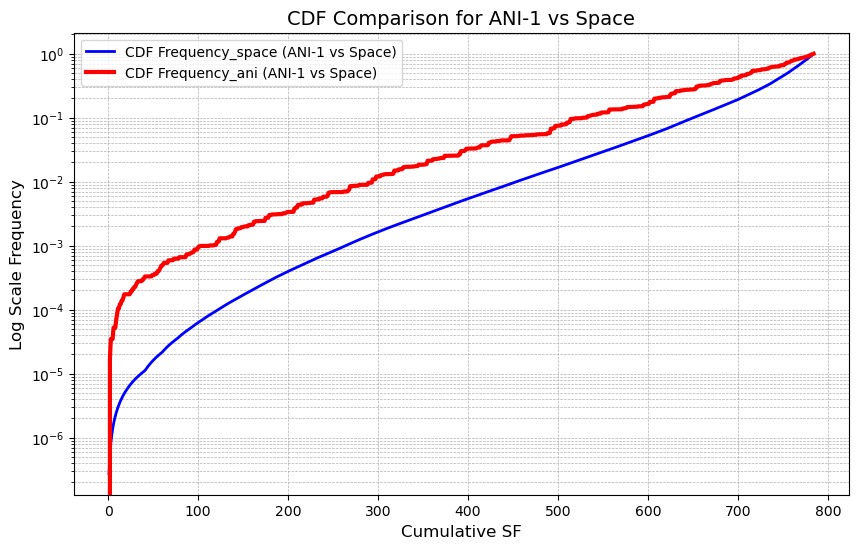

In [15]:
#1
plot_cdfs(data_frame=merged_ani, 
        distribution_one="Frequency_space", 
        distribution_two="Frequency_ani", 
        dataset_name="ANI-1 vs Space")

In [16]:
#2
metrics = calculate_metrics(merged_ani, "Frequency_space", "Frequency_ani")

Calculated Metrics:
                                            Metric      Value
                                      KS Statistic   0.260336
                       Area under Distribution One 462.828143
                       Area under Distribution Two 405.394187
                             Area between the CDFs  62.157875
Percentage Area Difference (relative to max curve)  13.430012
                            KL Divergence (P || Q)   1.291691


In [17]:
# Define sample franctions and n_bootstrap
sample_sizes_list = [0.001, 0.01, 0.1, 0.15, 0.2, 0.5, 0.8, 1.0]  # from 0,1% to 100%
sample_sizes_list = [0.001, 0.01, 0.1, 0.15, 0.2]  # from 0,1% to 20%
n_bootstrap, alpha = 1000, 0.05

In [18]:
#3
confidence_intervals = bootstrap_metrics(merged_ani, 
                                        "Frequency_space",
                                        "Frequency_ani", 
                                        n_bootstrap, 
                                        alpha)

Metric    Value Confidence Interval
    KS 0.083822      [0.044, 0.143]
 KL_PQ 1.300831      [1.048, 1.575]


In [19]:
display(metrics, confidence_intervals) #print all

,Metric,Value
0,KS Statistic,0.260336
1,Area under Distribution One,462.828143
2,Area under Distribution Two,405.394187
3,Area between the CDFs,62.157875
4,Percentage Area Difference (relative to max cu...,13.430012
5,KL Divergence (P || Q),1.291691


,Metric,Value,Confidence Interval
0,KS,0.083822,"[0.044, 0.143]"
1,KL_PQ,1.300831,"[1.048, 1.575]"


In [20]:
merged_ani

,SF,Frequency_space,Frequency_ani
0,C2,1,0.0
1,C2H10N4,37,0.0
2,C2H10N4O,315,0.0
3,C2H10N4O2,1824,0.0
4,C2H10N6,1646,3.0
...,...,...,...
779,O4,1,0.0
780,O5,1,0.0
781,O6,1,0.0
782,O7,1,0.0


# Random Sampling 


#### Space vs Space subsets

In [21]:
# Normalise the frequency of each sum formula in the space
merged_ani["Space_weight"] = merged_ani["Frequency_space"] / merged_ani["Frequency_space"].sum()

merged_ani["ani_weight"] = merged_ani["Frequency_ani"] / merged_ani["Frequency_ani"].sum()
merged_ani

,SF,Frequency_space,Frequency_ani,Space_weight,ani_weight
0,C2,1,0.0,2.730374e-07,0.000000
1,C2H10N4,37,0.0,1.010238e-05,0.000000
2,C2H10N4O,315,0.0,8.600678e-05,0.000000
3,C2H10N4O2,1824,0.0,4.980202e-04,0.000000
4,C2H10N6,1646,3.0,4.494195e-04,0.000052
...,...,...,...,...,...
779,O4,1,0.0,2.730374e-07,0.000000
780,O5,1,0.0,2.730374e-07,0.000000
781,O6,1,0.0,2.730374e-07,0.000000
782,O7,1,0.0,2.730374e-07,0.000000


In [22]:
sample_sizes_list = [0.00001, 0.0001, 0.001, 0.01, 0.015, 0.1, 0.5, 0.9, 1]
n_repeats = 100
alpha = 0.05

In [23]:
# Inputs
sample_sizes_list = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.015, 0.1, 0.5, 0.9, 1]
n_repeats = 100
alpha = 0.05

# Total number of molecules already calculated
total_molecules = merged_ani['Frequency_space'].sum()
print(f"Total molecules = {total_molecules:,}")

# Results storage
results = []

for frac in sample_sizes_list:
    s_size = int(frac * total_molecules)

    ks_vals = []
    kl_vals = []
    for _ in range(n_repeats):
        # Random sampling based on Space_weight
        probabilities = merged_ani["Space_weight"].values / merged_ani["Space_weight"].sum()
        counts = np.random.multinomial(s_size, probabilities)
        df_sample = pd.DataFrame({
            'SF': merged_ani.index,
            'Selected_molecules': counts
        })

        # Calculate Space_weight for the subspace
        df_sample["Space_weight_sampled"] = df_sample["Selected_molecules"] / df_sample["Selected_molecules"].sum()

        # Normalize original Space_weight
        merged_ani["Space_weight_normalized"] = merged_ani["Space_weight"] / merged_ani["Space_weight"].sum()

        # Calculate KS
        ks_stat = np.max(np.abs(merged_ani["Space_weight_normalized"].cumsum() - df_sample["Space_weight_sampled"].cumsum()))
        KS = ks_stat
        ks_vals.append(KS)

        # Calculate KL divergence
        p = df_sample["Space_weight_sampled"]
        q = merged_ani["Space_weight_normalized"]
        KL_PQ = entropy(p, q)  # KL divergence
        kl_vals.append(KL_PQ)
    
    ks_mean = np.mean(ks_vals)
    kl_mean = np.mean(kl_vals)
    lower_p = 100 * (alpha / 2)
    upper_p = 100 * (1 - alpha / 2)
    ks_low, ks_up = np.percentile(ks_vals, [lower_p, upper_p])
    kl_low, kl_up = np.percentile(kl_vals, [lower_p, upper_p])
    
    results.append({
        "Sample Fraction": frac,
        "Sample Size": s_size,
        "KS_Mean": ks_mean,
        "KS_CI_95": f"[{ks_low:.4f}, {ks_up:.4f}]",
        "KL_PQ_Mean": kl_mean,
        "KL_PQ_CI_95": f"[{kl_low:.4f}, {kl_up:.4f}]"
    })

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)

display(results_df)

Total molecules = 3,662,502


,Sample Fraction,Sample Size,KS_Mean,KS_CI_95,KL_PQ_Mean,KL_PQ_CI_95
0,0.000001,3,0.473824,"[0.2428, 0.7947]",3.856104,"[2.8021, 5.7933]"
1,0.000010,36,0.126334,"[0.0685, 0.2191]",1.590929,"[1.2574, 1.9700]"
2,0.000100,366,0.043086,"[0.0220, 0.0744]",0.394493,"[0.3411, 0.4544]"
3,0.001000,3662,0.013096,"[0.0071, 0.0221]",0.067001,"[0.0596, 0.0773]"
4,0.010000,36625,0.004272,"[0.0022, 0.0076]",0.009138,"[0.0083, 0.0101]"
5,0.015000,54937,0.003463,"[0.0019, 0.0058]",0.006306,"[0.0056, 0.0070]"
6,0.100000,366250,0.001307,"[0.0007, 0.0022]",0.001054,"[0.0010, 0.0012]"
7,0.500000,1831251,0.000589,"[0.0003, 0.0010]",0.000221,"[0.0002, 0.0002]"
8,0.900000,3296251,0.000467,"[0.0002, 0.0008]",0.000122,"[0.0001, 0.0001]"
9,1.000000,3662502,0.000404,"[0.0002, 0.0007]",0.000109,"[0.0001, 0.0001]"


In [24]:
#Export the dataframe as a .csv file
results_df.to_csv("ani_1.csv", index=False)

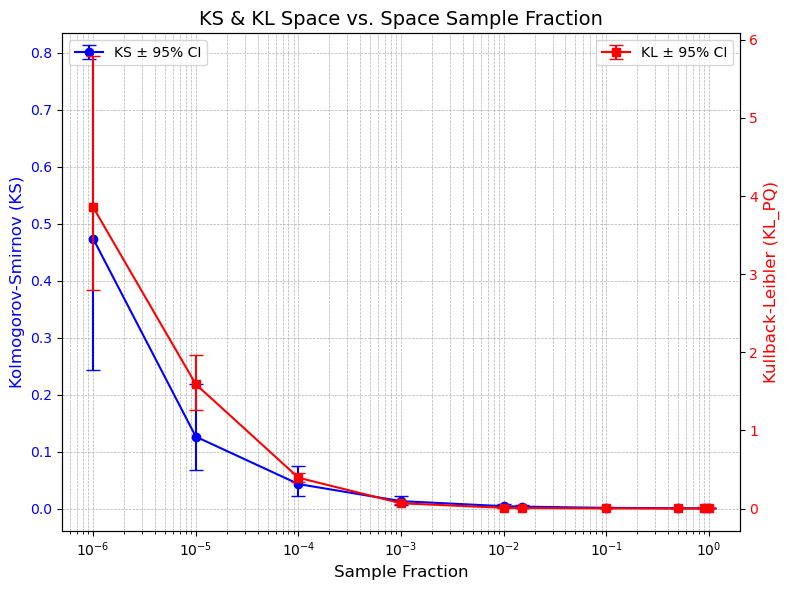

In [25]:
# Extract data
fractions = results_df["Sample Fraction"]

# KS Data
ks_means = results_df["KS_Mean"]
ks_cis = results_df["KS_CI_95"].str.strip("[]").str.split(", ").apply(lambda x: [float(v) for v in x])
ks_lower = [mean - ci[0] if mean >= ci[0] else 0 for mean, ci in zip(ks_means, ks_cis)]
ks_upper = [ci[1] - mean if ci[1] >= mean else 0 for mean, ci in zip(ks_means, ks_cis)]

# KL Data
kl_means = results_df["KL_PQ_Mean"]
kl_cis = results_df["KL_PQ_CI_95"].str.strip("[]").str.split(", ").apply(lambda x: [float(v) for v in x])
kl_lower = [mean - ci[0] if mean >= ci[0] else 0 for mean, ci in zip(kl_means, kl_cis)]
kl_upper = [ci[1] - mean if ci[1] >= mean else 0 for mean, ci in zip(kl_means, kl_cis)]

# Create figure and first Y-axis (KS)
fig, ax1 = plt.subplots(figsize=(8, 6))

ax1.set_xscale("log")
ax1.set_xlabel("Sample Fraction", fontsize=12)
ax1.set_ylabel("Kolmogorov-Smirnov (KS)", color="blue", fontsize=12)
ax1.errorbar(fractions, ks_means, yerr=[ks_lower, ks_upper], fmt='o-', color="blue", capsize=5, label="KS ± 95% CI")
ax1.tick_params(axis='y', labelcolor="blue")

# Create second Y-axis (KL)
ax2 = ax1.twinx()
ax2.set_ylabel("Kullback-Leibler (KL_PQ)", color="red", fontsize=12)
ax2.errorbar(fractions, kl_means, yerr=[kl_lower, kl_upper], fmt='s-', color="red", capsize=5, label="KL ± 95% CI")
ax2.tick_params(axis='y', labelcolor="red")

# Title and Grid
plt.title("KS & KL Space vs. Space Sample Fraction", fontsize=14)
ax1.grid(True, which="both", linestyle="--", linewidth=0.5)

# Legends
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()

## ANI vs ANI subsets

In [26]:
# Inputs
sample_sizes_list = [0.00001, 0.0001, 0.001, 0.01, 0.015, 0.1, 0.5, 0.9, 1]
n_repeats = 100
alpha = 0.05

from scipy.stats import entropy  # Import to calculate KL divergence

# Total number of molecules already calculated
total_molecules = merged_ani['Frequency_ani'].sum()
print(f"Total molecules = {total_molecules:,}")

# Results storage
results = []

for frac in sample_sizes_list:
    s_size = int(frac * total_molecules)
    if s_size < 1:
        s_size = 1
    ks_vals = []
    kl_vals = []
    for _ in range(n_repeats):
        # Random sampling based on ani_weight
        probabilities = merged_ani["ani_weight"].values / merged_ani["ani_weight"].sum()
        counts = np.random.multinomial(s_size, probabilities)
        df_sample = pd.DataFrame({
            'SF': merged_ani.index,
            'Selected_molecules': counts
        })

        # Calculate ani_weight for the subspace
        df_sample["ani_weight_sampled"] = df_sample["Selected_molecules"] / df_sample["Selected_molecules"].sum()

        # Normalize original ani_weight
        merged_ani["ani_weight_normalized"] = merged_ani["ani_weight"] / merged_ani["ani_weight"].sum()

        # Calculate KS
        ks_stat = np.max(np.abs(merged_ani["ani_weight_normalized"].cumsum() - df_sample["ani_weight_sampled"].cumsum()))
        KS = ks_stat
        ks_vals.append(KS)

        # Calculate KL divergence
        p = df_sample["ani_weight_sampled"]
        q = merged_ani["ani_weight_normalized"]
        KL_PQ = entropy(p, q)  # KL divergence
        kl_vals.append(KL_PQ)
    
    ks_mean = np.mean(ks_vals)
    kl_mean = np.mean(kl_vals)
    lower_p = 100 * (alpha / 2)
    upper_p = 100 * (1 - alpha / 2)
    ks_low, ks_up = np.percentile(ks_vals, [lower_p, upper_p])
    kl_low, kl_up = np.percentile(kl_vals, [lower_p, upper_p])
    
    results.append({
        "Sample Fraction": frac,
        "Sample Size": s_size,
        "KS_Mean": ks_mean,
        "KS_CI_95": f"[{ks_low:.4f}, {ks_up:.4f}]",
        "KL_PQ_Mean": kl_mean,
        "KL_PQ_CI_95": f"[{kl_low:.4f}, {kl_up:.4f}]"
    })

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)

display(results_df)


Total molecules = 57,462.0


,Sample Fraction,Sample Size,KS_Mean,KS_CI_95,KL_PQ_Mean,KL_PQ_CI_95
0,0.00001,1,0.756740,"[0.5363, 0.9887]",4.782989,"[3.4214, 8.8794]"
1,0.00010,5,0.348725,"[0.1780, 0.5728]",3.248107,"[2.4553, 4.2969]"
2,0.00100,57,0.102484,"[0.0576, 0.1810]",1.142010,"[0.9108, 1.3840]"
3,0.01000,574,0.034933,"[0.0186, 0.0557]",0.247856,"[0.2176, 0.2891]"
4,0.01500,861,0.027501,"[0.0158, 0.0474]",0.179276,"[0.1525, 0.2142]"
5,0.10000,5746,0.011084,"[0.0057, 0.0204]",0.036814,"[0.0326, 0.0413]"
6,0.50000,28731,0.004713,"[0.0025, 0.0083]",0.008363,"[0.0075, 0.0094]"
7,0.90000,51715,0.003570,"[0.0019, 0.0065]",0.004683,"[0.0042, 0.0052]"
8,1.00000,57462,0.003206,"[0.0017, 0.0060]",0.004194,"[0.0038, 0.0046]"


In [27]:
#Export the dataframe as a .csv file
results_df.to_csv("ani_2.csv", index=False)

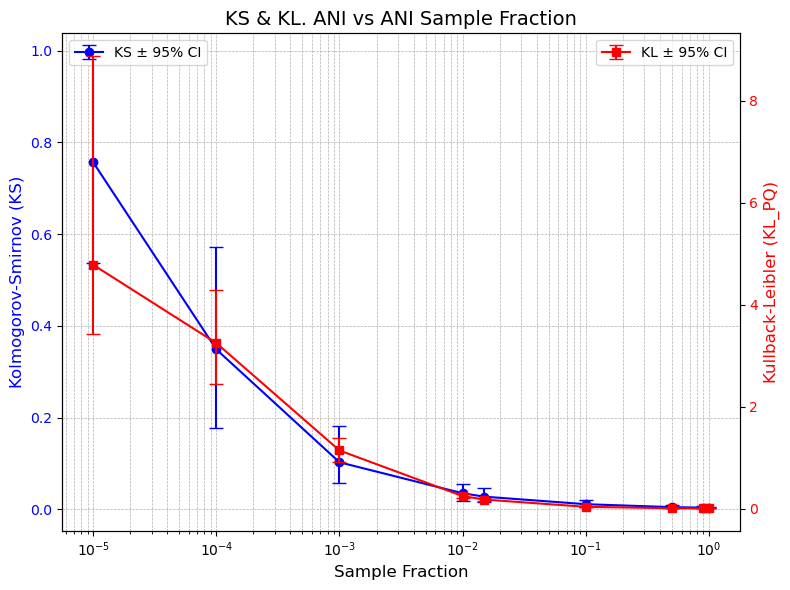

In [28]:
# Extract data
fractions = results_df["Sample Fraction"]

# KS Data
ks_means = results_df["KS_Mean"]
ks_cis = results_df["KS_CI_95"].str.strip("[]").str.split(", ").apply(lambda x: [float(v) for v in x])
ks_lower = [mean - ci[0] if mean >= ci[0] else 0 for mean, ci in zip(ks_means, ks_cis)]
ks_upper = [ci[1] - mean if ci[1] >= mean else 0 for mean, ci in zip(ks_means, ks_cis)]

# KL Data
kl_means = results_df["KL_PQ_Mean"]
kl_cis = results_df["KL_PQ_CI_95"].str.strip("[]").str.split(", ").apply(lambda x: [float(v) for v in x])
kl_lower = [mean - ci[0] if mean >= ci[0] else 0 for mean, ci in zip(kl_means, kl_cis)]
kl_upper = [ci[1] - mean if ci[1] >= mean else 0 for mean, ci in zip(kl_means, kl_cis)]

# Create figure and first Y-axis (KS)
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot KS
ax1.set_xscale("log")
ax1.set_xlabel("Sample Fraction", fontsize=12)
ax1.set_ylabel("Kolmogorov-Smirnov (KS)", color="blue", fontsize=12)
ax1.errorbar(fractions, ks_means, yerr=[ks_lower, ks_upper], fmt='o-', color="blue", capsize=5, label="KS ± 95% CI")
ax1.tick_params(axis='y', labelcolor="blue")

# Create second Y-axis (KL)
ax2 = ax1.twinx()
ax2.set_ylabel("Kullback-Leibler (KL_PQ)", color="red", fontsize=12)
ax2.errorbar(fractions, kl_means, yerr=[kl_lower, kl_upper], fmt='s-', color="red", capsize=5, label="KL ± 95% CI")
ax2.tick_params(axis='y', labelcolor="red")

# Title and Grid
plt.title("KS & KL. ANI vs ANI Sample Fraction", fontsize=14)
ax1.grid(True, which="both", linestyle="--", linewidth=0.5)

# Legends
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()

# ANI vs. Space sub sets

In [29]:
sample_sizes_list = [1e-5, 0.0001, 0.001, 0.01, 0.015, 0.1, 0.5, 0.9, 1]

# Results storage
results = []

for frac in sample_sizes_list:
    s_size = int(frac * total_molecules_space)
    ks_vals = []
    kl_vals = []
    
    for _ in range(n_repeats):
        # Random sampling from Space
        probabilities_space = merged_ani["Frequency_space"].values / merged_ani["Frequency_space"].sum()
        counts_space = np.random.multinomial(s_size, probabilities_space)
        df_sample_space = pd.DataFrame({
            'SF': merged_ani.index,
            'Selected_molecules': counts_space
        })

        # Calculate sampled Space weights
        df_sample_space["space_weight_sampled"] = df_sample_space["Selected_molecules"] / df_sample_space["Selected_molecules"].sum()

        # Normalize QM weights
        merged_ani["ani_weight_normalized"] = merged_ani["Frequency_ani"] / merged_ani["Frequency_ani"].sum()

        # Add smoothing to avoid division by zero or log(0)
        df_sample_space["space_weight_sampled"] += 1e-10
        merged_ani["ani_weight_normalized"] += 1e-10

        # Calculate KS
        ks_stat = np.max(np.abs(
            merged_ani["ani_weight_normalized"].cumsum() - df_sample_space["space_weight_sampled"].cumsum()
        ))
        KS = ks_stat
        ks_vals.append(KS)

        # Calculate KL divergence
        p = df_sample_space["space_weight_sampled"]
        q = merged_ani["ani_weight_normalized"]
        KL_PQ = entropy(p, q)  # KL divergence
        kl_vals.append(KL_PQ)
    
    # Calculate statistics
    ks_mean = np.mean(ks_vals)
    kl_mean = np.mean(kl_vals)
    lower_p = 100 * (alpha / 2)
    upper_p = 100 * (1 - alpha / 2)
    ks_low, ks_up = np.percentile(ks_vals, [lower_p, upper_p])
    kl_low, kl_up = np.percentile(kl_vals, [lower_p, upper_p])
    
    results.append({
        "Sample Fraction": frac,
        "Sample Size": s_size,
        "KS_Mean": ks_mean,
        "KS_CI_95": f"[{ks_low:.4f}, {ks_up:.4f}]",
        "KL_PQ_Mean": kl_mean,
        "KL_PQ_CI_95": f"[{kl_low:.4f}, {kl_up:.4f}]"
    })

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)

display(results_df)

,Sample Fraction,Sample Size,KS_Mean,KS_CI_95,KL_PQ_Mean,KL_PQ_CI_95
0,0.00001,36,0.296622,"[0.1791, 0.4120]",2.941795,"[2.0747, 3.9905]"
1,0.00010,366,0.266599,"[0.2194, 0.3065]",1.658497,"[1.3989, 2.0318]"
2,0.00100,3662,0.260552,"[0.2432, 0.2754]",1.363875,"[1.2723, 1.4738]"
3,0.01000,36625,0.260729,"[0.2550, 0.2653]",1.300814,"[1.2727, 1.3289]"
4,0.01500,54937,0.260631,"[0.2560, 0.2645]",1.298363,"[1.2762, 1.3201]"
5,0.10000,366250,0.260353,"[0.2589, 0.2618]",1.292727,"[1.2854, 1.3024]"
6,0.50000,1831251,0.260339,"[0.2598, 0.2608]",1.292107,"[1.2886, 1.2961]"
7,0.90000,3296251,0.260362,"[0.2598, 0.2609]",1.291797,"[1.2885, 1.2951]"
8,1.00000,3662502,0.260333,"[0.2599, 0.2607]",1.291696,"[1.2891, 1.2941]"


In [30]:
#Export the dataframe as a .csv file
results_df.to_csv("ani_3.csv", index=False)

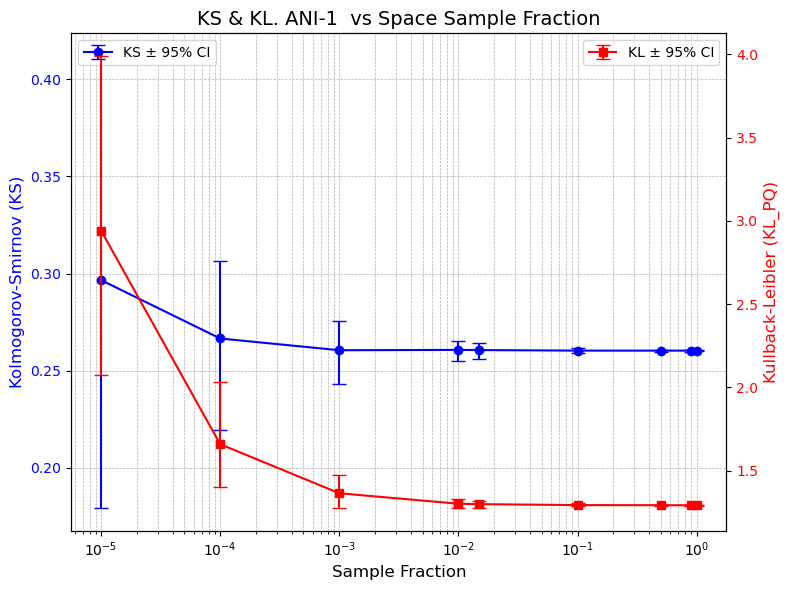

In [31]:
# Extract data
fractions = results_df["Sample Fraction"]

#KS Data
ks_means = results_df["KS_Mean"]
ks_cis = results_df["KS_CI_95"].str.strip("[]").str.split(", ").apply(lambda x: [float(v) for v in x])
ks_lower = [mean - ci[0] if mean >= ci[0] else 0 for mean, ci in zip(ks_means, ks_cis)]
ks_upper = [ci[1] - mean if ci[1] >= mean else 0 for mean, ci in zip(ks_means, ks_cis)]

# KL Data
kl_means = results_df["KL_PQ_Mean"]
kl_cis = results_df["KL_PQ_CI_95"].str.strip("[]").str.split(", ").apply(lambda x: [float(v) for v in x])
kl_lower = [mean - ci[0] if mean >= ci[0] else 0 for mean, ci in zip(kl_means, kl_cis)]
kl_upper = [ci[1] - mean if ci[1] >= mean else 0 for mean, ci in zip(kl_means, kl_cis)]

# Create figure and first Y-axis (KS)
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot KS
ax1.set_xscale("log")
ax1.set_xlabel("Sample Fraction", fontsize=12)
ax1.set_ylabel("Kolmogorov-Smirnov (KS)", color="blue", fontsize=12)
ax1.errorbar(fractions, ks_means, yerr=[ks_lower, ks_upper], fmt='o-', color="blue", capsize=5, label="KS ± 95% CI")
ax1.tick_params(axis='y', labelcolor="blue")

# Create second Y-axis (KL)
ax2 = ax1.twinx()
ax2.set_ylabel("Kullback-Leibler (KL_PQ)", color="red", fontsize=12)
ax2.errorbar(fractions, kl_means, yerr=[kl_lower, kl_upper], fmt='s-', color="red", capsize=5, label="KL ± 95% CI")
ax2.tick_params(axis='y', labelcolor="red")

# Title and Grid
plt.title("KS & KL. ANI-1  vs Space Sample Fraction", fontsize=14)
ax1.grid(True, which="both", linestyle="--", linewidth=0.5)

# Legends
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()

# Chemical Space vs ANI-1 Sample Fraction

In [32]:
sample_sizes_list = [0.0001, 0.001, 0.01, 0.1, 1] #solo base 10
results = []

for frac in sample_sizes_list:
    s_size = int(frac * total_molecules_ani)
    ks_vals = []
    kl_vals = []

    for _ in range(n_repeats):
        
        # 1. Smapling
        probabilities = merged_ani["Frequency_ani"].values / merged_ani["Frequency_ani"].sum()
        counts = np.random.multinomial(s_size, probabilities)
        df_sample = pd.DataFrame({
            'SF': merged_ani.index,
            'Selected_molecules': counts
        })

        df_sample["ani_weight_sampled"] = df_sample["Selected_molecules"] / df_sample["Selected_molecules"].sum()

        # 2. Ref: Space
        merged_ani["space_weight_normalized"] = merged_ani["Frequency_space"] / merged_ani["Frequency_space"].sum()

        # 3. Add smoothing to avoid division by zero or log(0)
        df_sample["ani_weight_sampled"] += 1e-10
        merged_ani["space_weight_normalized"] += 1e-10

        # 4. KS
        ks_stat = np.max(np.abs(
            merged_ani["space_weight_normalized"].cumsum() - df_sample["ani_weight_sampled"].cumsum()
        ))
        ks_vals.append(ks_stat)

        # 5. KL
        p = df_sample["ani_weight_sampled"]
        q = merged_ani["space_weight_normalized"]
        KL_PQ = entropy(p, q)
        kl_vals.append(KL_PQ)

    # Final statistics
    ks_mean = np.mean(ks_vals)
    kl_mean = np.mean(kl_vals)
    lower_p = 100 * (alpha / 2)
    upper_p = 100 * (1 - alpha / 2)
    ks_low, ks_up = np.percentile(ks_vals, [lower_p, upper_p])
    kl_low, kl_up = np.percentile(kl_vals, [lower_p, upper_p])

    results.append({
        "Sample Fraction": frac,
        "Sample Size": s_size,
        "KS_Mean": ks_mean,
        "KS_CI_95": f"[{ks_low:.4f}, {ks_up:.4f}]",
        "KL_PQ_Mean": kl_mean,
        "KL_PQ_CI_95": f"[{kl_low:.4f}, {kl_up:.4f}]"
    })

results_df = pd.DataFrame(results)
display(results_df)


,Sample Fraction,Sample Size,KS_Mean,KS_CI_95,KL_PQ_Mean,KL_PQ_CI_95
0,0.0001,5,0.440203,"[0.2391, 0.7250]",4.183612,"[3.0111, 6.0035]"
1,0.0010,57,0.293734,"[0.1826, 0.4127]",2.237711,"[1.8251, 2.6092]"
2,0.0100,574,0.267224,"[0.2390, 0.3022]",1.330742,"[1.1985, 1.4518]"
3,0.1000,5746,0.260675,"[0.2514, 0.2733]",1.112308,"[1.0724, 1.1498]"
4,1.0000,57462,0.260123,"[0.2567, 0.2638]",1.075906,"[1.0635, 1.0869]"


In [33]:
#Export the dataframe as a .csv file
results_df.to_csv("ani_4.csv", index=False)

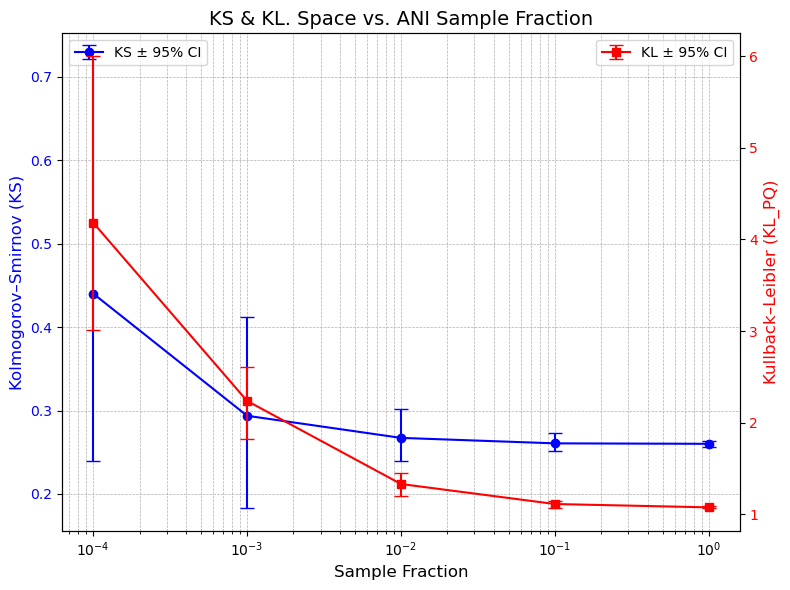

In [34]:
# Extract data  
fractions = results_df["Sample Fraction"]

# KS
ks_means = results_df["KS_Mean"]
ks_cis = results_df["KS_CI_95"].str.strip("[]").str.split(", ").apply(lambda x: [float(v) for v in x])
ks_lower = [mean - ci[0] if mean >= ci[0] else 0 for mean, ci in zip(ks_means, ks_cis)]
ks_upper = [ci[1] - mean if ci[1] >= mean else 0 for mean, ci in zip(ks_means, ks_cis)]

# KL
kl_means = results_df["KL_PQ_Mean"]
kl_cis = results_df["KL_PQ_CI_95"].str.strip("[]").str.split(", ").apply(lambda x: [float(v) for v in x])
kl_lower = [mean - ci[0] if mean >= ci[0] else 0 for mean, ci in zip(kl_means, kl_cis)]
kl_upper = [ci[1] - mean if ci[1] >= mean else 0 for mean, ci in zip(kl_means, kl_cis)]

# Create figure and first Y-axis (KS)
fig, ax1 = plt.subplots(figsize=(8, 6))

# KS plot
ax1.set_xscale("log")
ax1.set_xlabel("Sample Fraction", fontsize=12)
ax1.set_ylabel("Kolmogorov–Smirnov (KS)", color="blue", fontsize=12)
ax1.errorbar(fractions, ks_means, yerr=[ks_lower, ks_upper],
             fmt='o-', color="blue", capsize=5, label="KS ± 95% CI")
ax1.tick_params(axis='y', labelcolor="blue")

# KL plot
ax2 = ax1.twinx()
ax2.set_ylabel("Kullback–Leibler (KL_PQ)", color="red", fontsize=12)
ax2.errorbar(fractions, kl_means, yerr=[kl_lower, kl_upper],
             fmt='s-', color="red", capsize=5, label="KL ± 95% CI")
ax2.tick_params(axis='y', labelcolor="red")

plt.title("KS & KL. Space vs. ANI Sample Fraction", fontsize=14)
ax1.grid(True, which="both", linestyle="--", linewidth=0.5)
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()